In [1]:
!pip install kaggle

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install plotly

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install lightgbm

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import gc, math, pickle, datetime, os, random
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
def reduce_mem_usage(df, verbose=True):
    """
    :param df: Dataframe with columns unprocessed so they use more memory than needed
    
    :returns:
        df -> Dataframe with lower memory use
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def clean_timestamps(df):
    """
    :param df: Dataframe containing a "timestamp" field which will be broken down in hour, year, day,...
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df["year"] = df["timestamp"].dt.year.astype(np.uint16)
    df["month"] = df["timestamp"].dt.month.astype(np.uint8)
    df["day"] = df["timestamp"].dt.day.astype(np.uint8)
    df["hour"] = df["timestamp"].dt.hour.astype(np.uint8)
    df["weekend"] = df["timestamp"].dt.weekday.astype(np.uint8)
    
def drop_cols(df):
    """
    :param df: Dataframe with unnecessary cols
    
    :returns:
            df -> dataframe containing only the desired columns
    """
    #drop_cols = ['timestamp','primary_use', 'site_id', 'floor_count',"precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed", "building_id"]
    drop_cols = ['timestamp']
    df = df.drop(drop_cols, axis = 1)
    return df

# Predictions lower than zero are turned zero
def fix_predictions(y):
    """
    :param y: Column with predictions
    """
    y[y < 0] = 0

# Predictibility in our predictions
def seed_everything(seed=0):
    """
    :param seed: Value for seeding random functions
    """
    random.seed(seed)
    np.random.seed(seed)

# Fill given categories with their average values
def fill_averages(df):
    """
    :param df: Dataframe containing normal and nan values
    """
    data_ratios = df.count()/len(df)
    cols = data_ratios[data_ratios < 1.0].index
    for col in cols:
        df[col] = df[col].fillna(-1)
        df[col] = df[col].astype(np.int8)
        more_zero = df[col] >= 0
        less_zero = df[col] < 0
        mean = df[more_zero][col].mean()
        df.loc[less_zero, col] = mean

In [7]:
SEED = 5
seed_everything(SEED)

## Download the dataset

We need the api keys, either write it down here or export kaggle's json file to ~/.kaggle/kaggle.json

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "*****"
os.environ['KAGGLE_KEY'] = "****"
!kaggle competitions download -c ashrae-energy-prediction


In [ ]:
!unzip ashrae-energy-prediction.zip

In [ ]:
!mkdir ashrae-energy-prediction
!mv *.csv ashrae-energy-prediction

In [8]:
PATH = 'ashrae-energy-prediction/'
train_df = reduce_mem_usage(pd.read_csv(PATH + 'train.csv'))
building = reduce_mem_usage(pd.read_csv(PATH + 'building_metadata.csv'))
weather_train = reduce_mem_usage(pd.read_csv(PATH + 'weather_train.csv'))

train_merged = train_df.merge(building, left_on = "building_id", right_on = "building_id", how = "left")
train = train_merged.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"])

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [9]:
test = reduce_mem_usage(pd.read_csv(PATH + '/test.csv'))

Mem. usage decreased to 596.49 Mb (53.1% reduction)


In [10]:
print(train.shape)
print(test.shape)

(20125605, 16)
(41697600, 4)


## Preprocessing

In [11]:
clean_timestamps(train)

## EDA and Visualizing the Data

In [12]:
train.head(2)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,weekend
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,...,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,...,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4


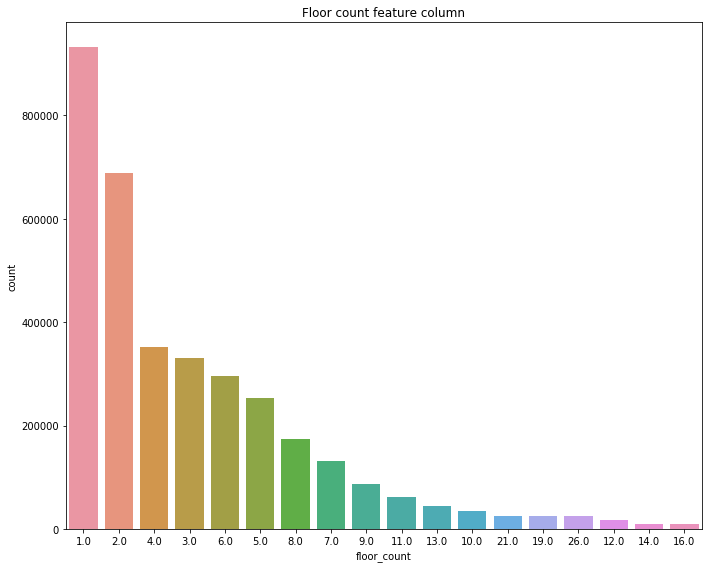

In [13]:
plt.figure(figsize=(10, 8))
sns.countplot(x="floor_count",data=train, order = train['floor_count'].value_counts().index)
plt.title('Floor count feature column')
plt.tight_layout()
plt.show()

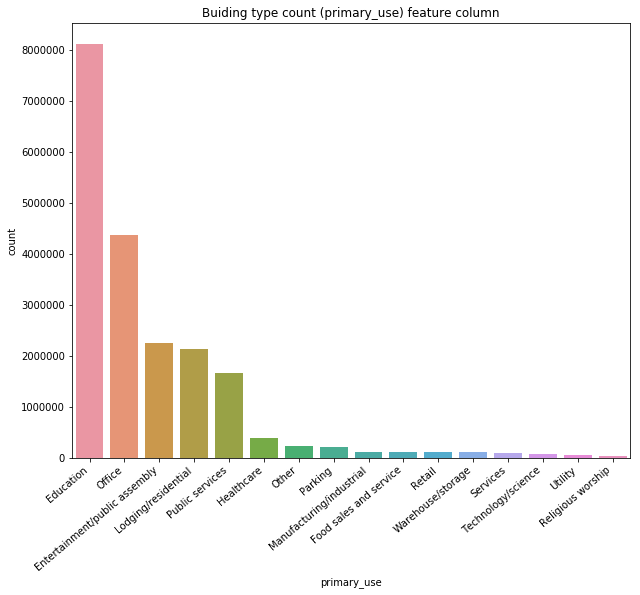

In [14]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(x="primary_use",data=train, order = train['primary_use'].value_counts().index)
plt.title('Buiding type count (primary_use) feature column')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

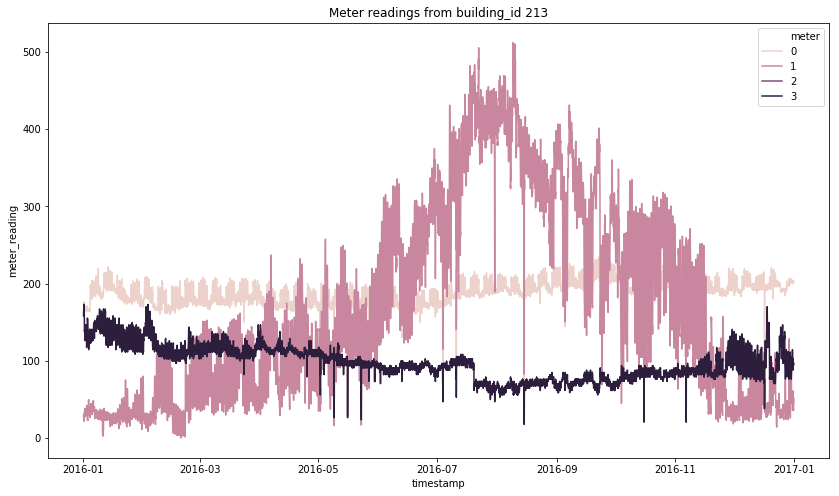

In [15]:

building_id = 213
plt.figure(figsize=(14, 8))
ax = sns.lineplot(x="timestamp", y="meter_reading", hue="meter", data=train[train['building_id'] == building_id])
plt.title('Meter readings from building_id {}'.format(building_id))
plt.show()

In [16]:
train = drop_cols(train)

train_y = np.log1p(train['meter_reading'])

train_x = train.drop('meter_reading', axis=1)
train_x['primary_use'] = LabelEncoder().fit_transform(train_x['primary_use'])

train_x.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,weekend
0,0,0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4
1,1,0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4
2,2,0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4
3,3,0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4
4,4,0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,2016,1,1,0,4


In [17]:
del train
#del train_x
#del train_y 

gc.collect()

3630

## Creating the LightGBM model

In [18]:
# Train and Validation splits
test_size = 0.20
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=test_size, random_state=SEED)

In [19]:
  lgb_params = {
                    'objective':'regression',
                    'boosting_type':'gbdt',
                    'metric':'rmse',
                    'n_jobs':-1,
                    'learning_rate':0.07,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,
                    'n_estimators':8500,
                    'max_bin':255,
                    'verbose':1,
                    'seed': SEED,
                    'early_stopping_rounds':3500, 
                } 

In [20]:
del train_x
del train_y

gc.collect()

7

In [21]:
# load model once already trained
#print('Loading model')
#gbm = lgb.Booster(model_file= PATH + 'lgb_classifier_24-10-2019.txt')

In [22]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)
gbm = lgb.train(lgb_params,
            lgb_train,
            num_boost_round=5000,
            valid_sets=(lgb_train, lgb_eval),
            verbose_eval = 50
           )

/anaconda/envs/py35/lib/python3.5/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda/envs/py35/lib/python3.5/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 3500 rounds.
[50]	training's rmse: 1.11594	valid_1's rmse: 1.11477
[100]	training's rmse: 0.956311	valid_1's rmse: 0.955395
[150]	training's rmse: 0.884643	valid_1's rmse: 0.884169
[200]	training's rmse: 0.843284	valid_1's rmse: 0.843267
[250]	training's rmse: 0.810433	valid_1's rmse: 0.810881
[300]	training's rmse: 0.782482	valid_1's rmse: 0.783389
[350]	training's rmse: 0.765615	valid_1's rmse: 0.766962
[400]	training's rmse: 0.749006	valid_1's rmse: 0.750854
[450]	training's rmse: 0.732211	valid_1's rmse: 0.734492
[500]	training's rmse: 0.720293	valid_1's rmse: 0.723053
[550]	training's rmse: 0.707155	valid_1's rmse: 0.710459
[600]	training's rmse: 0.696821	valid_1's rmse: 0.70067
[650]	training's rmse: 0.68862	valid_1's rmse: 0.692862
[700]	training's rmse: 0.680826	valid_1's rmse: 0.685583
[750]	training's rmse: 0.674548	valid_1's rmse: 0.679767
[800]	training's rmse: 0.668201	valid_1's rmse: 0.673915
[850]	training's rmse: 0.6602

[7150]	training's rmse: 0.46146	valid_1's rmse: 0.513835
[7200]	training's rmse: 0.460921	valid_1's rmse: 0.51359
[7250]	training's rmse: 0.460391	valid_1's rmse: 0.513332
[7300]	training's rmse: 0.4598	valid_1's rmse: 0.513028
[7350]	training's rmse: 0.459178	valid_1's rmse: 0.512656
[7400]	training's rmse: 0.458585	valid_1's rmse: 0.512367
[7450]	training's rmse: 0.457971	valid_1's rmse: 0.51205
[7500]	training's rmse: 0.457369	valid_1's rmse: 0.511764
[7550]	training's rmse: 0.45675	valid_1's rmse: 0.511453
[7600]	training's rmse: 0.45619	valid_1's rmse: 0.511161
[7650]	training's rmse: 0.45556	valid_1's rmse: 0.510833
[7700]	training's rmse: 0.454988	valid_1's rmse: 0.510546
[7750]	training's rmse: 0.454473	valid_1's rmse: 0.510281
[7800]	training's rmse: 0.45395	valid_1's rmse: 0.510047
[7850]	training's rmse: 0.453392	valid_1's rmse: 0.509785
[7900]	training's rmse: 0.452794	valid_1's rmse: 0.509491
[7950]	training's rmse: 0.452222	valid_1's rmse: 0.509212
[8000]	training's rmse:

# Predicting validation data

In [23]:
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

## Postprocessing

In [24]:
fix_predictions(y_pred)

## RMSLE 

In [25]:
rmsle = np.sqrt(mean_squared_log_error(y_pred, (y_val)))
print('RMSLE: ', rmsle)

RMSLE:  0.18960864144176456


## Saving the model

In [26]:
gbm.save_model('lgb_classifier_{}_{}.txt'.format(datetime.datetime.now().strftime("%d-%m-%Y"), rmsle), num_iteration=gbm.best_iteration)

## Feature Importance

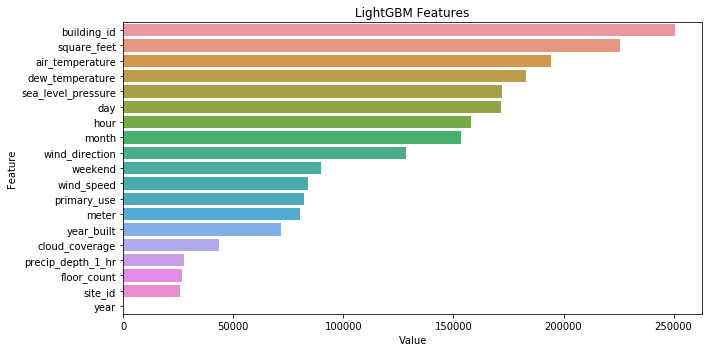

In [27]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

## Test preparation

In [31]:
building = reduce_mem_usage(pd.read_csv(PATH + 'building_metadata.csv'))
test = reduce_mem_usage(pd.read_csv(PATH + "test.csv"))
weather_test = reduce_mem_usage(pd.read_csv(PATH + "weather_test.csv"))

test = test.merge(building, left_on = "building_id", right_on = "building_id", how = "left")
test = test.merge(weather_test, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how="left")

del weather_test
del building
gc.collect()

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


256

In [32]:
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [33]:
clean_timestamps(test)
test = drop_cols(test)
test = test.drop('row_id', axis = 1)
test['primary_use'] = LabelEncoder().fit_transform(test['primary_use'])

In [34]:
submission = pd.read_csv('ashrae-energy-prediction/sample_submission.csv')

In [35]:
test_1 = test[:len(test)//3]
y_pred_1 = gbm.predict(test_1, num_iteration=gbm.best_iteration)

del test_1

gc.collect()

111

In [36]:
test_2 = test[len(test)//3:(len(test)*2)//3]
y_pred_2 = gbm.predict(test_2, num_iteration=gbm.best_iteration)

del test_2

gc.collect()

7

In [37]:
test_3 = test[(len(test)*2)//3:]
y_pred_3 = gbm.predict(test_3, num_iteration=gbm.best_iteration)

del test_3

gc.collect()

7

In [38]:
y_pred = np.concatenate([y_pred_1, y_pred_2, y_pred_3], axis=0)

del y_pred_1
del y_pred_2
del y_pred_3

gc.collect()

0

In [39]:
y_pred = np.expm1(y_pred)
fix_predictions(y_pred)
submission['meter_reading'] = y_pred
submission

,row_id,meter_reading
0,0,0.271430
1,1,0.432878
2,2,0.283880
3,3,0.273937
4,4,0.506358
5,5,0.339144
6,6,0.586382
7,7,0.572591
8,8,432.764301
9,9,0.335379


## Submission

In [40]:
submission.to_csv('submission.csv', index=False)

In [41]:
!kaggle competitions submit -c ashrae-energy-prediction -f submission.csv -m "First submission!"


100%|██████████████████████████████████████| 1.04G/1.04G [00:37<00:00, 29.9MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III